In [11]:
import pandas as pd
import numpy as np
import torch
import warnings
import sys, os

sys.path.append(os.path.abspath('..'))

ais_tracks_path = '../../data/tracks_ais.csv'
cleaned_detections_path = '../../data/cleaned_data/preprocessed_radar_detections.csv'
ais_tracks = pd.read_csv(ais_tracks_path)
radar_detections = pd.read_csv(cleaned_detections_path)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [12]:
from core.sum_stats import SumStats

sum_stats = SumStats(radar_detections)
summary_df = sum_stats()

In [13]:
summary_df.columns

Index(['id_track', 'duration', 'p95_speed', 'p5_speed', 'med_speed',
       'curviness', 'heading_mean', 'heading_std', 'turning_mean',
       'turning_std', 'distance_total', 'distance_o', 'detections',
       'type_m2_agg'],
      dtype='object')

In [14]:
import plotly.graph_objects as go


class DebugTrackPlotter:
    """
    Interactive Plotter for a single vessel track with hover and summary stats.
    Init Args:
        current_track: radar_detections corresponding to a single id_track
        ais_tracks: reference ais tracks
    """

    def __init__(self, current_track, ais_tracks):
        self.current_track = current_track
        self.ais_tracks = ais_tracks

    def plot_track(self):
        assert len(self.current_track['id_track'].unique()) == 1, "track_data must be associated with 1 track"
        num_detections = self.current_track.shape[0]
        current_assoc_id = self.current_track['assoc_id'].iloc[0]
        reference = self.ais_tracks[self.ais_tracks['id_track'] == current_assoc_id]

        # Compute per-point and summary stats
        group = SumStats.compute_track_features(self.current_track.copy())  # new helper below
        summary = SumStats.compute_track_stats(group)
        track_id = group['id_track'].iloc[0]

        # Format the title text
        summary_text = f"""
        <b>Track ID:</b> {track_id}<br>
        <b>Num Detections:</b>{num_detections}<br>
        <b>Vessel Type:<b> {reference['type_m2'].iloc[0]}<br><br>

        <b>Manual:</b><br>
        <b>Avg Speed:</b> {summary['avg_speed']:.2f} kn<br>
        <b>Max Speed:</b> {summary['max_speed']:.2f} kn<br>
        <b>Min Speed:</b> {summary['min_speed']:.2f} kn<br> 
        <b>Heading Mean:</b> {summary['heading_mean']:.2f}°<br>
        <b>Heading Std:</b> {summary['heading_std']:.2f}°<br>
        <b>Turning Mean:</b> {summary['turning_mean']:.2f}°<br>
        <b>Turning Std:</b> {summary['turning_std']:.2f}°<br><br>

        <b>AIS:</b><br>
        <b>Avg Speed:</b> {reference['avg_speed'].iloc[0]:.2f} kn<br>
        <b>Max Speed:</b> {reference['max_speed'].iloc[0]:.2f} kn<br>
        <b>Min Speed:</b> {reference['min_speed'].iloc[0]:.2f} kn<br>
        <b>Heading Mean:</b> {reference['heading_mean'].iloc[0]:.2f}°<br>
        <b>Heading Std:</b> {reference['heading_std'].iloc[0]:.2f}°<br>
        <b>Turning Mean:</b> {reference['turning_mean'].iloc[0]:.2f}°<br>
        <b>Turning Std:</b> {reference['turning_std'].iloc[0]:.2f}°
        """

        # Create hover text
        group['hover_text'] = (
            'Course: ' + group['course'].astype(str) +
            '<br>Speed: ' + group['speed'].astype(str) +
            '<br>Instant Speed (knots): ' + group['instant_speed'].round(2).astype(str) +
            '<br>Time Diff (s): ' + group['time_diff'].round(1).astype(str) +
            '<br>Heading Diff (°): ' + group['heading_diff'].round(2).astype(str)
        )

        fig = go.Figure()

        # Trajectory
        fig.add_trace(go.Scattergeo(
            lon=group['longitude'],
            lat=group['latitude'],
            mode='markers+lines',
            marker=dict(size=5, color='blue'),
            line=dict(width=1),
            text=group['hover_text'],
            hoverinfo='text',
            name='Trajectory'
        ))

        # Start point
        fig.add_trace(go.Scattergeo(
            lon=[group['longitude'].iloc[0]],
            lat=[group['latitude'].iloc[0]],
            mode='markers',
            marker=dict(size=10, color='green', symbol='triangle-up'),
            name='Start'
        ))

        # End point
        fig.add_trace(go.Scattergeo(
            lon=[group['longitude'].iloc[-1]],
            lat=[group['latitude'].iloc[-1]],
            mode='markers',
            marker=dict(size=10, color='red', symbol='triangle-down'),
            name='End'
        ))

        # Compute bounding box for automatic zoom
        min_lat, max_lat = group['latitude'].min(), group['latitude'].max()
        min_lon, max_lon = group['longitude'].min(), group['longitude'].max()
        center_lat = (min_lat + max_lat) / 2
        center_lon = (min_lon + max_lon) / 2

        # Estimate appropriate zoom/scale
        lat_range = max_lat - min_lat
        lon_range = max_lon - min_lon
        zoom_scale = max(lat_range, lon_range)
        zoom_scale = max(zoom_scale, 0.1)  # Avoid too tight zoom

        fig.update_layout(
            title=dict(text=summary_text, x=0.01, xanchor='left', yanchor='top',
                       font = dict(size = 12)),
            geo=dict(
                showland=True,
                landcolor='rgb(243, 243, 243)',
                countrycolor='rgb(204, 204, 204)',
                projection_type='equirectangular',
                showlakes=True,
                lakecolor='rgb(255, 255, 255)',
                resolution=50,
                center=dict(lat=center_lat, lon=center_lon),
                lataxis=dict(range=[min_lat - 0.05, max_lat + 0.05]),
                lonaxis=dict(range=[min_lon - 0.05, max_lon + 0.05]),
            ),
            margin={"r":0, "t":100, "l":0, "b":0}
        )
        fig.show()

### Examine SumStats

In [43]:
comparison[comparison['turning_mean_x'] >= 50]['id_track'].sample(10)

2600    31076261
2531    30932420
915     38373532
4950    37168803
2827    31804219
5420    38089939
4000    34663737
2608    31077759
2943    31996290
2512    30905012
Name: id_track, dtype: int64

In [44]:
debug_track = radar_detections[radar_detections['id_track'] ==31076261]
debug_plotter = DebugTrackPlotter(debug_track, ais_tracks)
debug_plotter.plot_track()


In [48]:
ais_tracks[ais_tracks['id_track'] == 31068366]['turning_mean']

2306    70.720396
Name: turning_mean, dtype: float64

### Plotting to Check Consistency

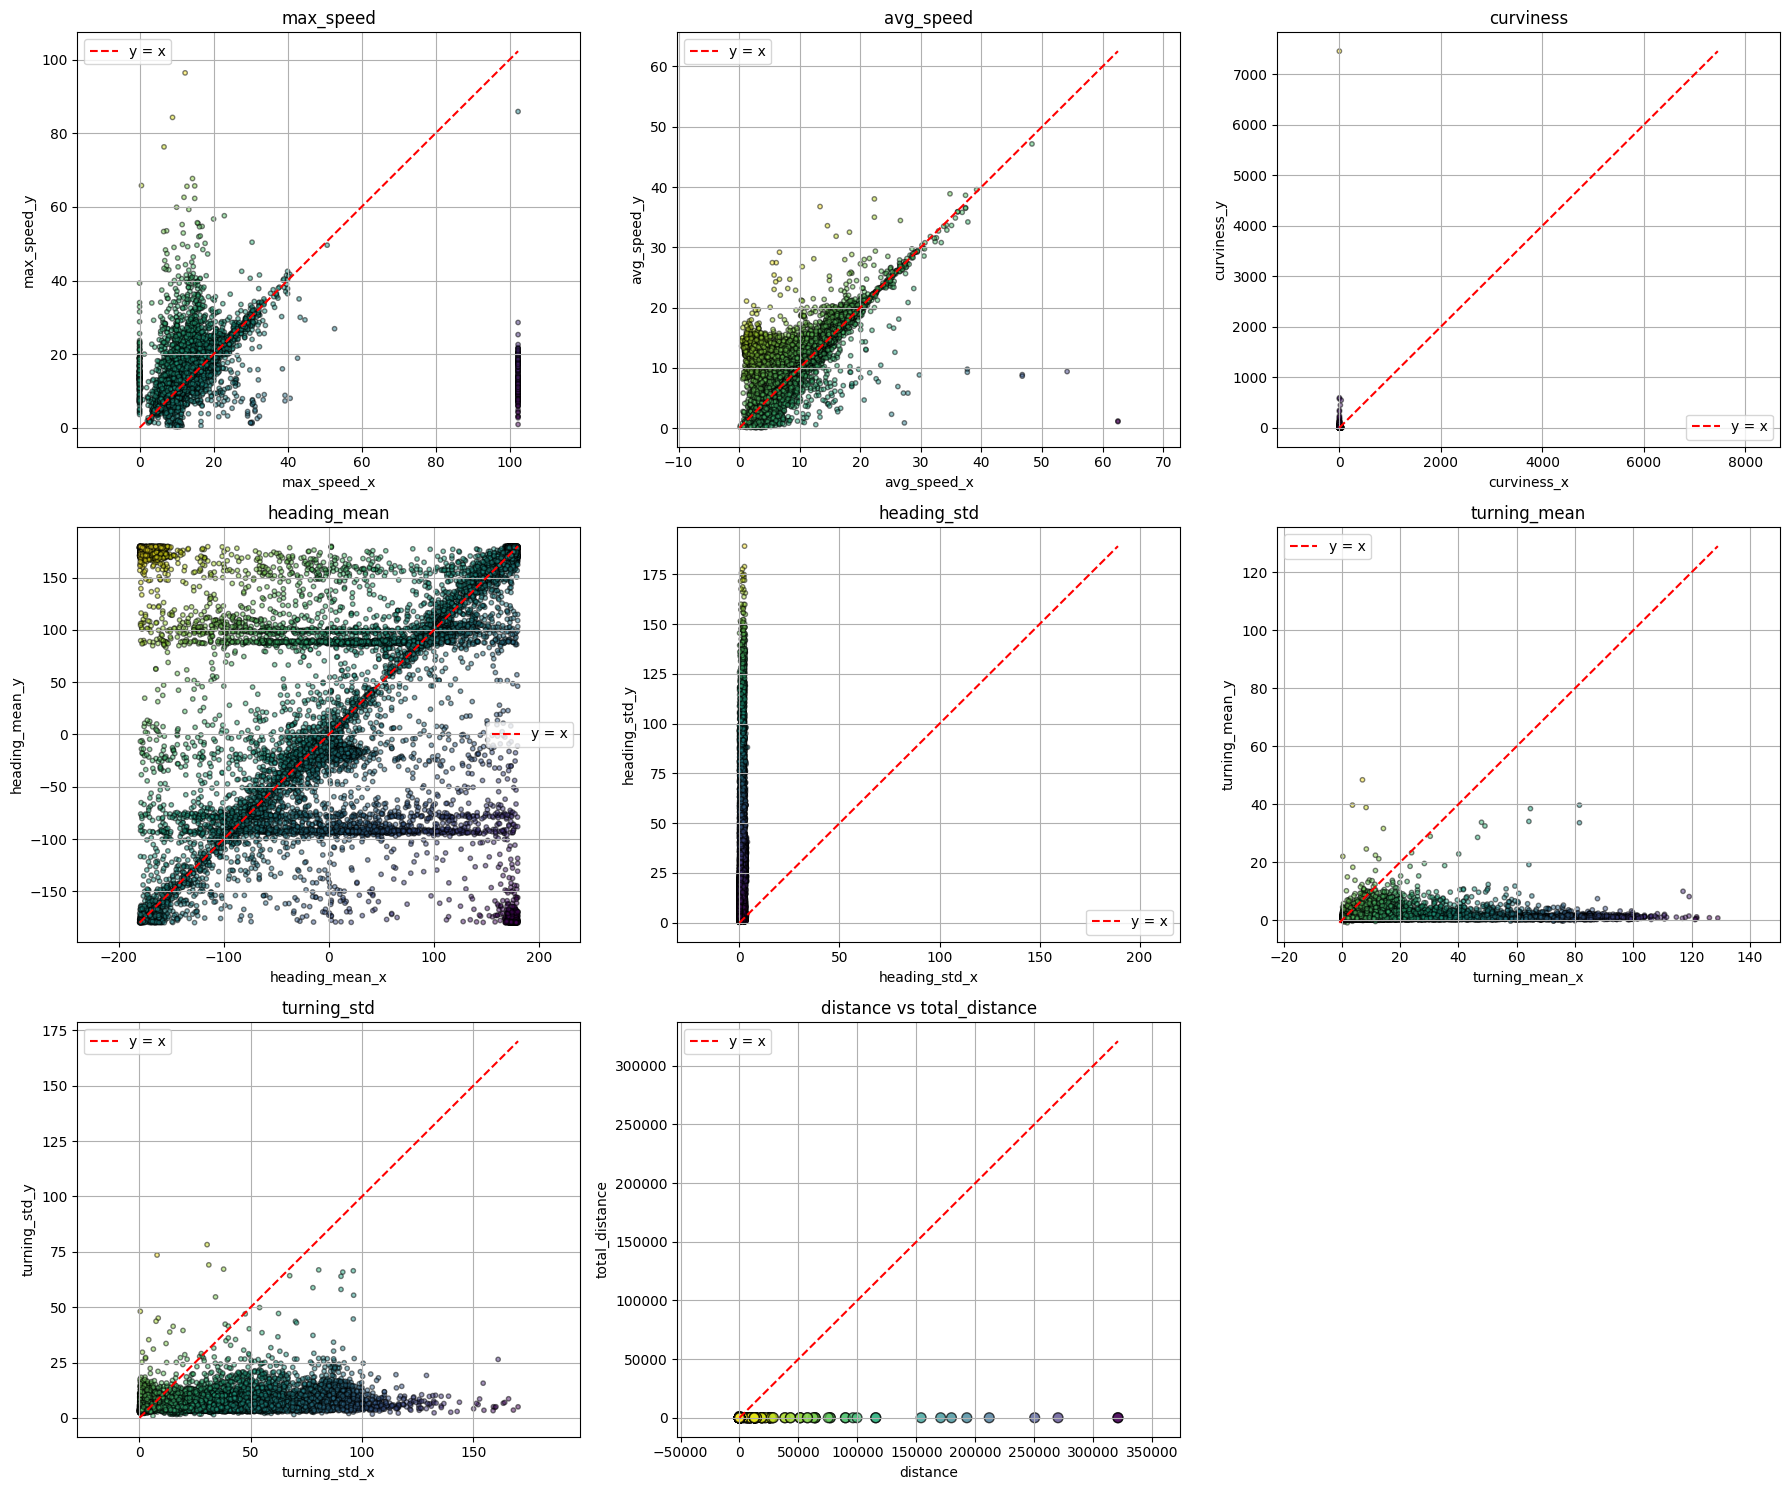

In [10]:
import matplotlib.pyplot as plt
import numpy as np

variables = [
    'max_speed', 'avg_speed', 'curviness',
    'heading_mean', 'heading_std',
    'turning_mean', 'turning_std'
]

n_cols = 3
n_rows = (len(variables) + 1 + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for i, var in enumerate(variables):
    x = comparison[f'{var}_x']
    y = comparison[f'{var}_y']
    color = y - x

    plt.subplot(n_rows, n_cols, i + 1)
    scatter = plt.scatter(
        x, y,
        c=color, cmap='viridis', s=10, alpha=0.5, edgecolor='k'
    )

    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel(f'{var}_x')
    plt.ylabel(f'{var}_y')
    plt.title(var)
    plt.axis('equal')
    plt.grid(True)
    plt.legend()

# Special case: distance vs total_distance
x = comparison['distance']
y = comparison['total_distance']
color = y - x

plt.subplot(n_rows, n_cols, len(variables) + 1)
scatter = plt.scatter(
    x, y,
    c=color, cmap='viridis', s=50, alpha=0.7, edgecolor='k'
)

min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel('distance')
plt.ylabel('total_distance')
plt.title('distance vs total_distance')
plt.axis('equal')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Type Classification

In [3]:
# #Use my version of track sumamry stats
# merged = pd.merge(ais_tracks, summary_df, left_on='id_track', right_on='assoc_id', how='inner')
# tagged_detections_track_stats = tagged_detections.groupby('id_track').apply(SumStats.compute_track_stats).reset_index()

# #Only drops ~1% possibly duplicate tracks
# tracks_tagged_no_assoc = tracks_tagged[tracks_tagged['assoc_id'].isna()]

# #Extract human labels as 'type_m2' for tagged_tracks
# #currently filter out lobster and fishing(non-lobster) boats
# tracks_tagged_no_assoc['type_m2'] = 'N/A'
# # Create mask for fishing boats (including fishing_c and fishing_r)
# fishing_mask = (
#     tracks_tagged_no_assoc['notes'].str.contains('fishing', case=False, na=False) | 
#     tracks_tagged_no_assoc['notes'].str.contains('lobster', case=False, na=False) | 
#     (tracks_tagged_no_assoc['fishing_c'] == 1) | 
#     (tracks_tagged_no_assoc['fishing_r'] == 1)
# )

# tracks_tagged_no_assoc.loc[fishing_mask, 'type_m2'] = 'fishing_boat'

# #~90% of the tagged tracks are missing meaningful labels though, drop them
# tracks_tagged_no_assoc = tracks_tagged_no_assoc[tracks_tagged_no_assoc['type_m2'] != 'N/A']

# tagged_detections_summary = pd.merge(tracks_tagged_no_assoc,tagged_detections_track_stats, on='id_track', how='inner')
# tagged_detections_summary.columns

# #merge two dataframes
# merged_two = pd.concat([merged, tagged_detections_summary], axis=0)

In [24]:
features_subset = [
    'p95_speed', 'p5_speed', 'med_speed',
       'curviness', 'heading_mean', 'heading_std', 'turning_mean',
       'turning_std', 'distance_o']


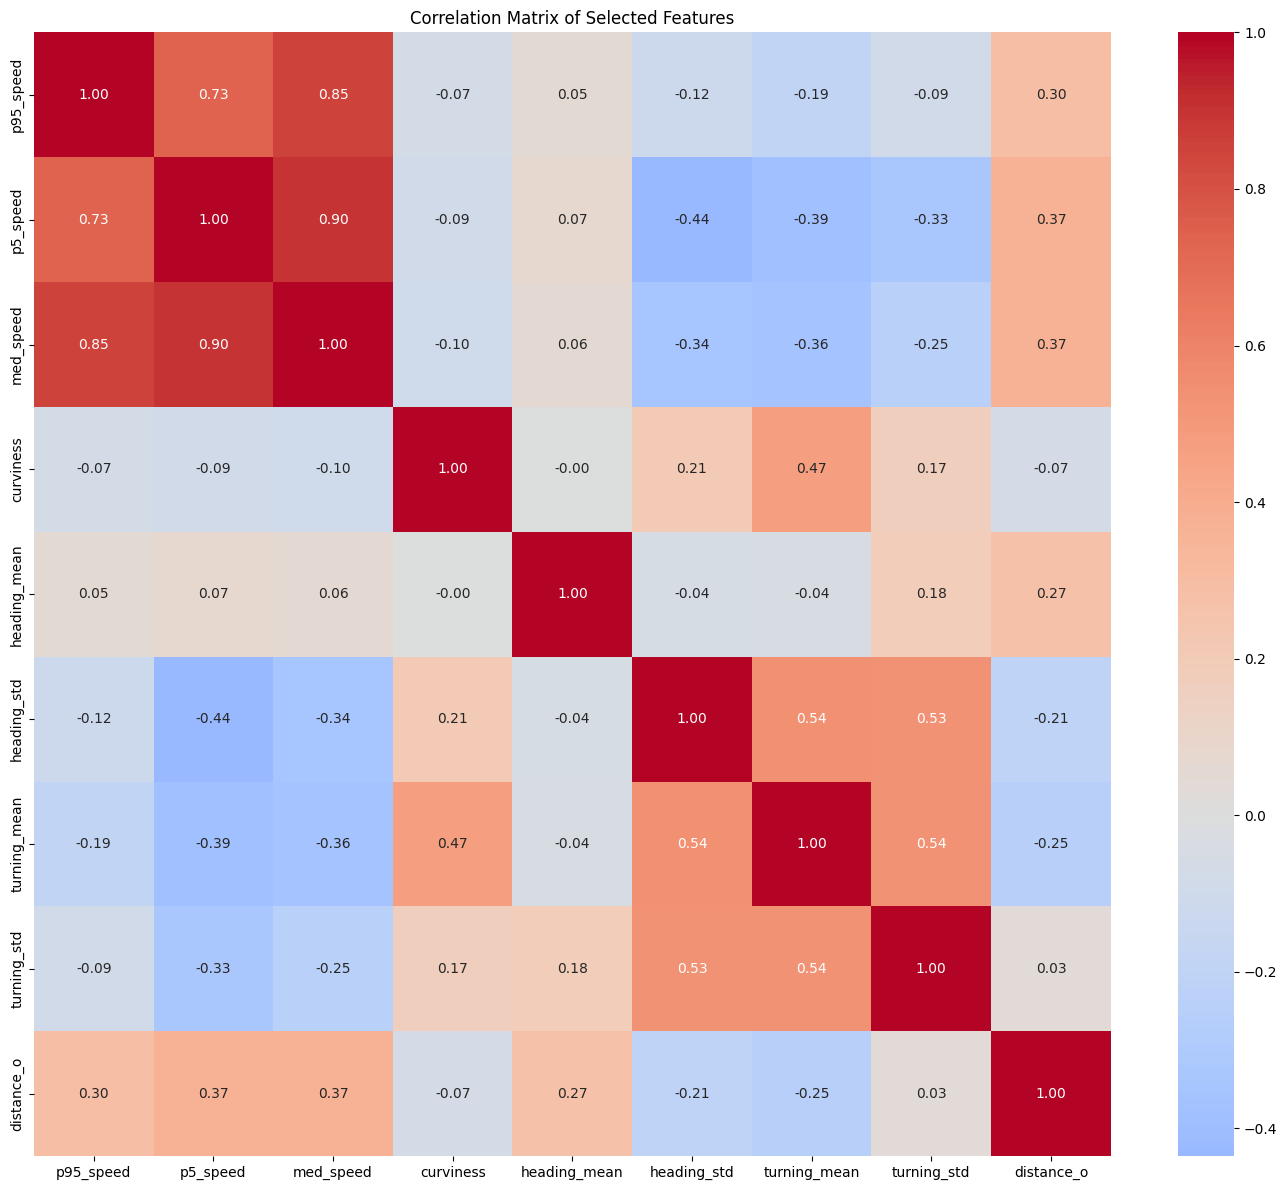

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = summary_df[features_subset].corr()

# Plot using seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()


In [26]:
summary_df['type_m2_agg'].value_counts()

type_m2_agg
cargo/tanker      6123
passenger_ship    2514
class_b           2415
other             1374
tug/tow            875
military_ship      449
pleasure_craft     291
fishing_boat       163
Name: count, dtype: int64

In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and target
X = summary_df[features_subset]
y = summary_df['type_m2_agg']

#Type to number mapping
ship2num, num2ship = {}, {}
num = 0
for vessel in y.unique():
    ship2num[vessel] = num
    num2ship[num] = vessel
    num += 1
y_numeric = y.map(ship2num)

# Train-test split (80:20), stratified sampling by vessel type
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)

# Define XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if you want probability outputs
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42
)

# Hyperparameter tuning (after a few tries)
param_grid = {
    'max_depth': [13],
    'learning_rate': [0.15],
    'n_estimators': [200]
}

# Perform 4-fold cross-validation with grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)


grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTest Set Accuracy: {:.4f}".format(test_accuracy))

Fitting 4 folds for each of 1 candidates, totalling 4 fits


Best parameters: {'learning_rate': 0.15, 'max_depth': 13, 'n_estimators': 200}
Best cross-validation accuracy: 0.7661

Test Set Accuracy: 0.7751


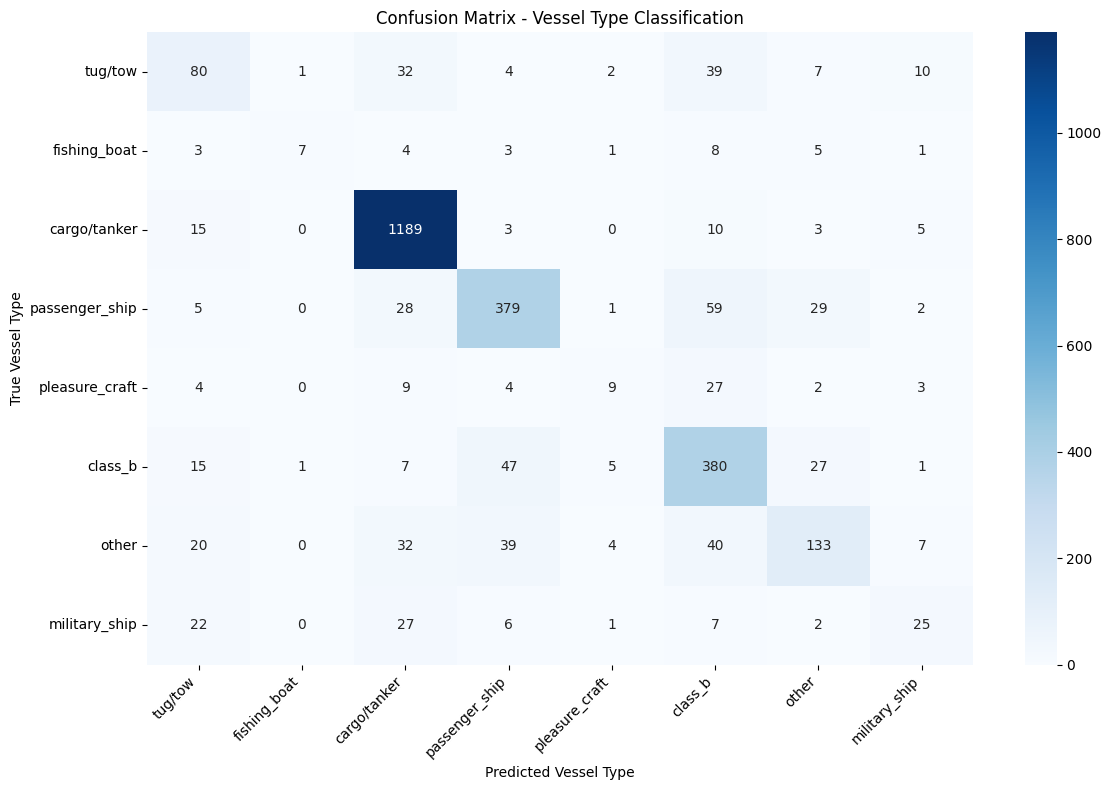

In [28]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

# Create heatmap of confusion matrix
sns.heatmap(cm, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='Blues',  # Use blue color scheme
            xticklabels=list(ship2num.keys()),  # Use vessel type names for x-axis
            yticklabels=list(ship2num.keys()))  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

# Print classification report for detailed metrics
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=list(ship2num.keys())))

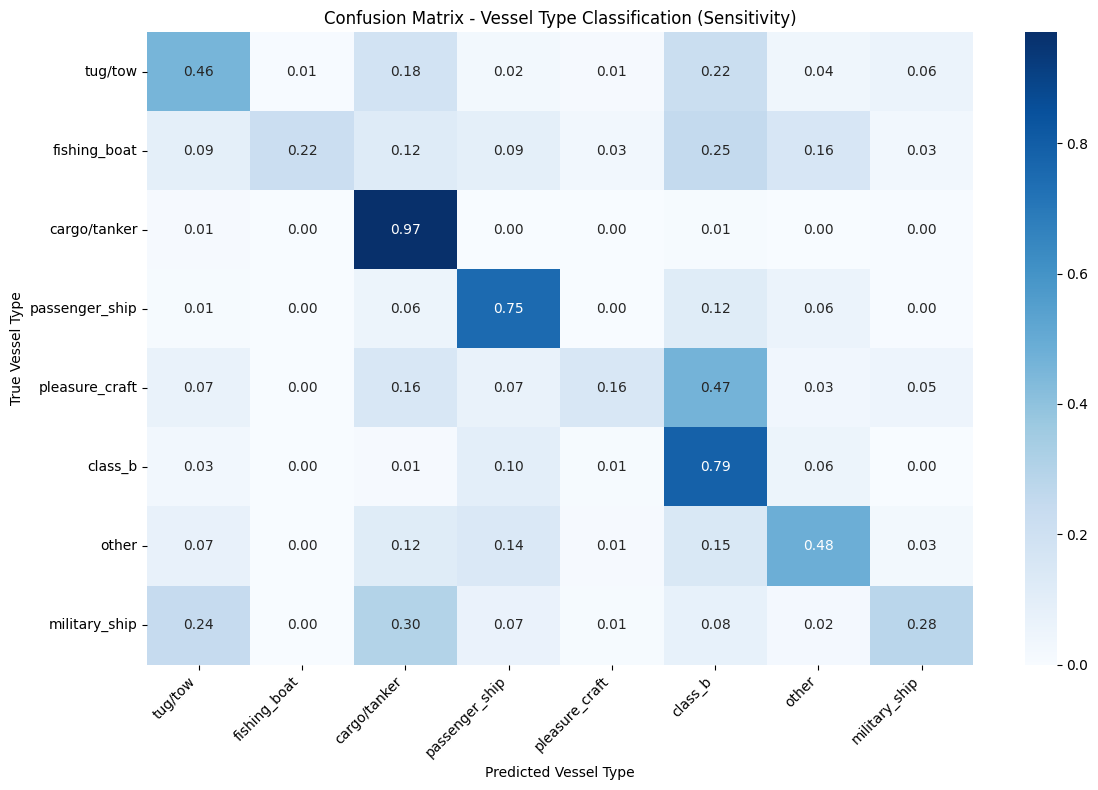

In [29]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (recall) for each class
sensitivity = cm.diagonal() / cm.sum(axis=1)

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

# Create a matrix where each row is normalized by the sum of that row
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Create heatmap of normalized confusion matrix
sns.heatmap(cm_normalized, 
            annot=True,  # Show numbers in cells
            fmt='.2f',   # Format as percentages
            cmap='Blues',  # Use blue color scheme
            xticklabels=y.unique(),  # Use vessel type names for x-axis
            yticklabels=y.unique())  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Vessel Type Classification (Sensitivity)')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

<Figure size 1000x800 with 0 Axes>

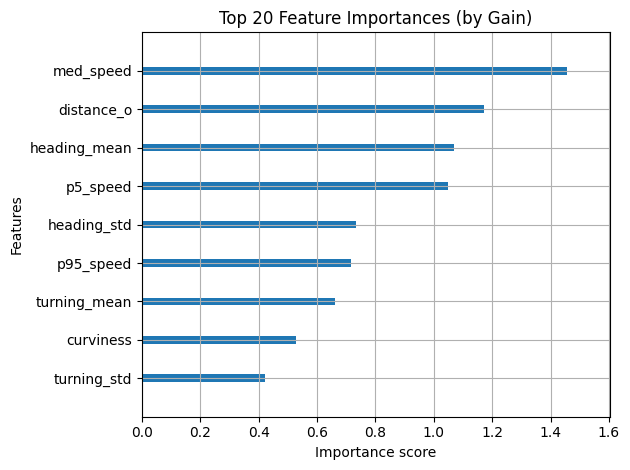

In [31]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, max_num_features=20, importance_type='gain', show_values=False)
plt.title('Top 20 Feature Importances (by Gain)')
plt.tight_layout()
plt.show()
